In [ ]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path
import os
import itertools



In [ ]:
# Download dataset
import kagglehub
dataset = kagglehub.dataset_download("vitaminc/cigarette-smoker-detection")

print("Path to dataset files:", dataset)






100%|██████████| 2.50G/2.50G [02:04<00:00, 21.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vitaminc/cigarette-smoker-detection/versions/1


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, walk_through_dir


--2024-12-18 21:48:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-12-18 21:48:56 (75.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Walk through dataset
dataset = "/root/.cache/kagglehub/datasets/vitaminc/cigarette-smoker-detection/versions/1"
walk_through_dir(dataset)

There are 1 directories and 0 images in '/root/.cache/kagglehub/datasets/vitaminc/cigarette-smoker-detection/versions/1'.
There are 3 directories and 1 images in '/root/.cache/kagglehub/datasets/vitaminc/cigarette-smoker-detection/versions/1/data'.
There are 2 directories and 1 images in '/root/.cache/kagglehub/datasets/vitaminc/cigarette-smoker-detection/versions/1/data/data'.
There are 0 directories and 1279 images in '/root/.cache/kagglehub/datasets/vitaminc/cigarette-smoker-detection/versions/1/data/data/not_smoking'.
There are 0 directories and 1996 images in '/root/.cache/kagglehub/datasets/vitaminc/cigarette-smoker-detection/versions/1/data/data/smoking'.
There are 0 directories and 1279 images in '/root/.cache/kagglehub/datasets/vitaminc/cigarette-smoker-detection/versions/1/data/not_smoking'.
There are 0 directories and 1996 images in '/root/.cache/kagglehub/datasets/vitaminc/cigarette-smoker-detection/versions/1/data/smoking'.


In [ ]:
# Filepaths and labels extraction
image_dir = Path(dataset)
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + \
            list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.jpeg'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Combine filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)



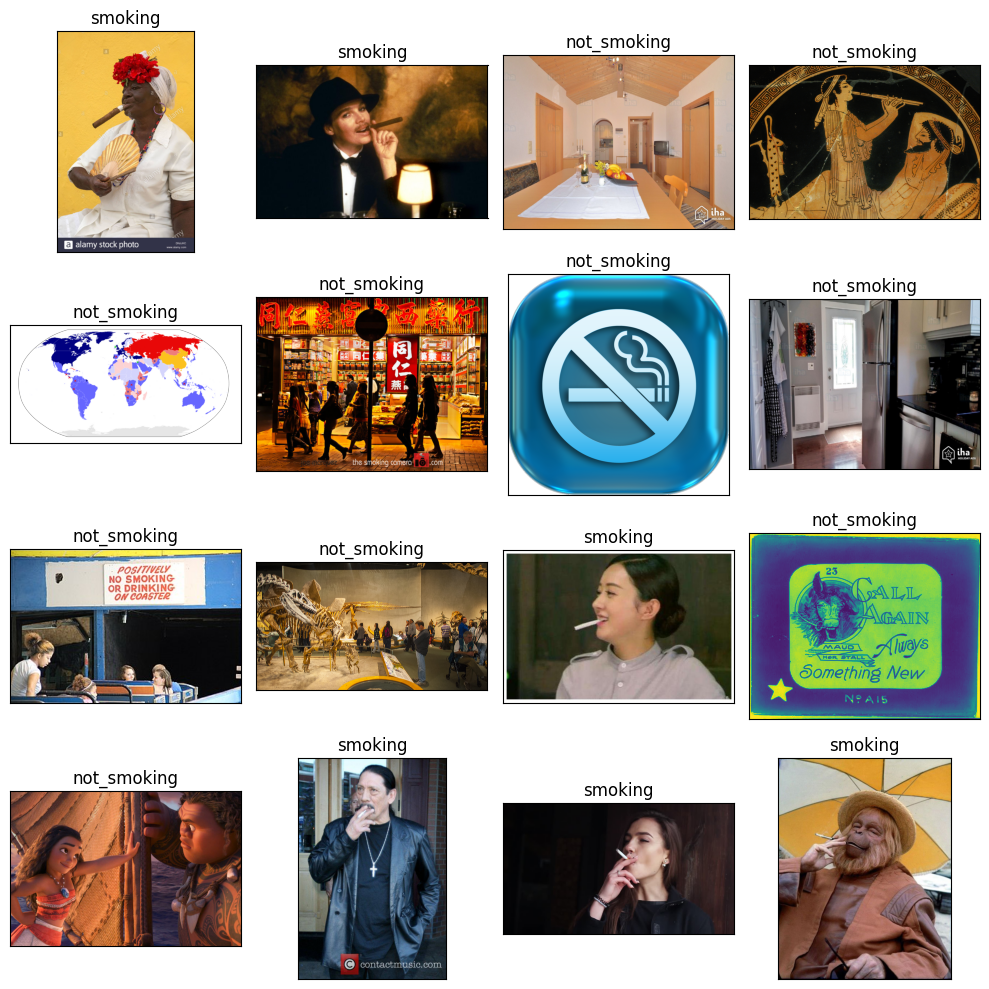

In [ ]:
# Display 16 sample images
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()



In [ ]:
# Split data into train and test
train_df, test_df = train_test_split(image_df, test_size=0.2, random_state=42, shuffle=True)

# ImageDataGenerator without augmentation
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

# Split into train, validation, and test
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)



Found 4157 validated image filenames belonging to 2 classes.
Found 1039 validated image filenames belonging to 2 classes.
Found 1300 validated image filenames belonging to 2 classes.


In [ ]:
# Model Definition
pretrained_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='max')
pretrained_model.trainable = False

inputs = pretrained_model.input
x = Dense(512, activation='relu')(pretrained_model.output)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Get the number of classes from the class_indices attribute
num_classes = len(train_images.class_indices)

# Use num_classes in the output layer
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# Callbacks
checkpoint_path = "smokers_classification_model_resnet50.weights.h5"
checkpoint_callback = ModelCheckpoint(
    checkpoint_path, save_weights_only=True, monitor="val_accuracy", save_best_only=True
)
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)




In [ ]:
# Model Training
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", "smoker_classification_resnet50"),
        checkpoint_callback
    ]
)



Saving TensorBoard log files to: training_logs/smoker_classification_resnet50/20241218-214912
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 56/130 ━━━━━━━━━━━━━━━━━━━━ 54s 741ms/step - accuracy: 0.5427 - loss: 6.2513

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


130/130 ━━━━━━━━━━━━━━━━━━━━ 127s 834ms/step - accuracy: 0.5927 - loss: 4.8135 - val_accuracy: 0.7988 - val_loss: 0.8197
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 97s 704ms/step - accuracy: 0.7216 - loss: 1.3557 - val_accuracy: 0.8383 - val_loss: 0.4098
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 97s 714ms/step - accuracy: 0.7609 - loss: 0.8268 - val_accuracy: 0.8431 - val_loss: 0.3716
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 95s 706ms/step - accuracy: 0.7614 - loss: 0.6360 - val_accuracy: 0.8537 - val_loss: 0.3442
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 93s 685ms/step - accuracy: 0.7763 - loss: 0.5380 - val_accuracy: 0.8306 - val_loss: 0.3568
Epoch 6/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 93s 679ms/step - accuracy: 0.8129 - loss: 0.4354 - val_accuracy: 0.8547 - val_loss: 0.3261
Epoch 7/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 142s 696ms/step - accuracy: 0.8259 - loss: 0.4241 - val_accuracy: 0.8643 - val_loss: 0.3054
Epoch 8/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 97s 706ms/step - accuracy: 0.8275 - loss: 0.3674 - v

In [ ]:
# Evaluate Model
results = model.evaluate(test_images, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))



    Test Loss: 0.21533
Test Accuracy: 92.85%


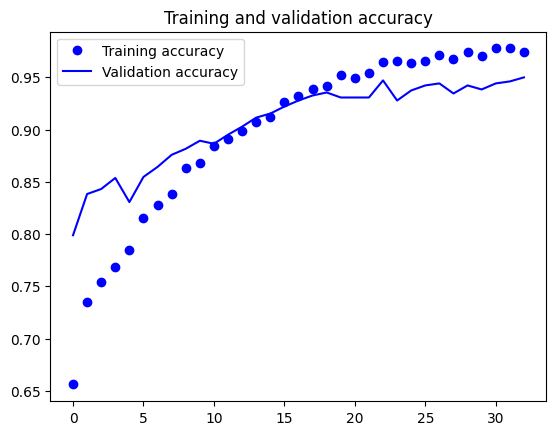

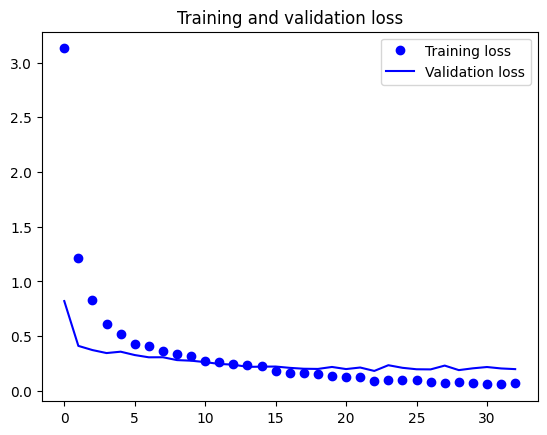

In [ ]:
# Plot Training and Validation Metrics
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(val_accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()



In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v, k) for k, v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')



41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 551ms/step
The first 5 predictions: ['not_smoking', 'smoking', 'smoking', 'smoking', 'smoking']


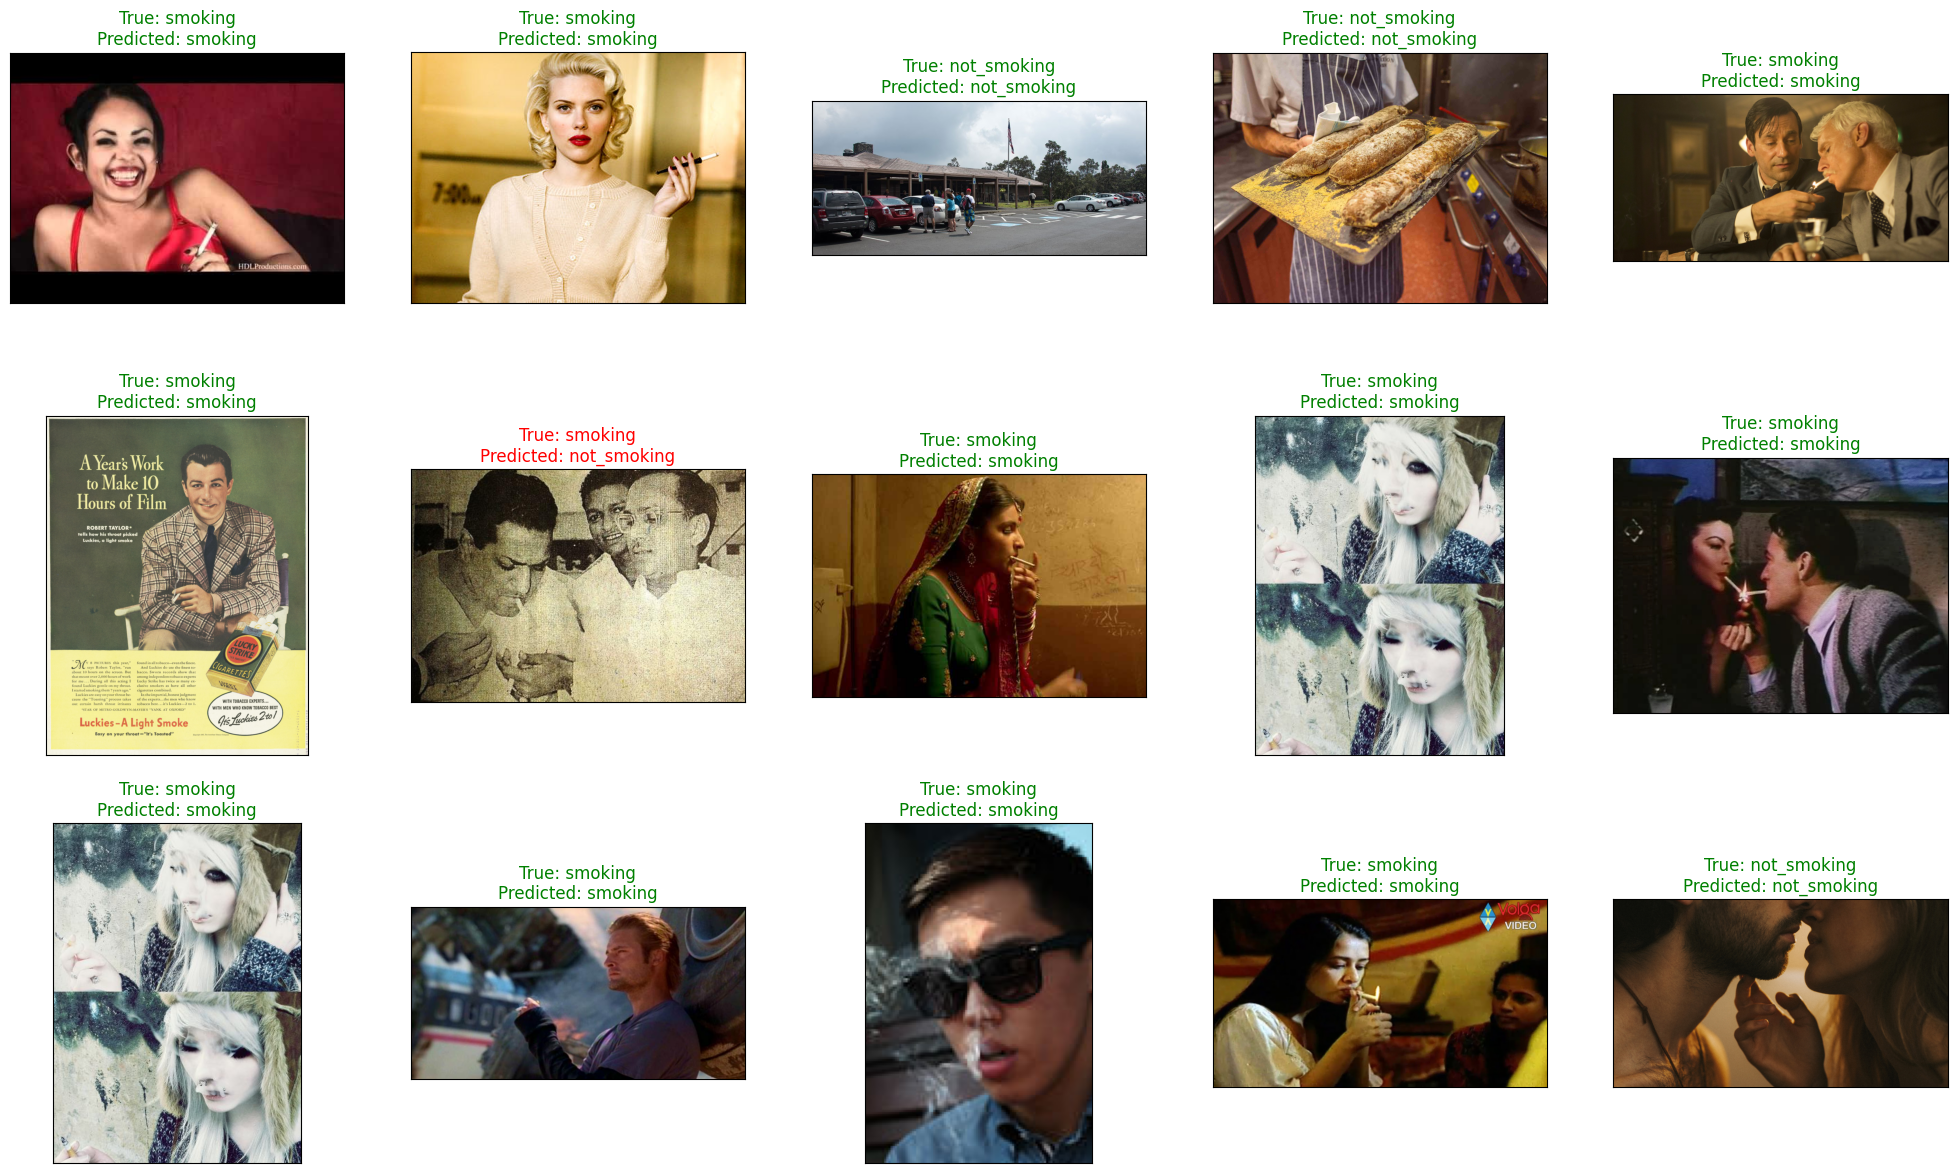

<Figure size 640x480 with 0 Axes>

In [ ]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

y_test = list(test_df.Label)



In [ ]:
# Use the same number of samples for y_test and pred
print(classification_report(y_test, pred))

report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df



              precision    recall  f1-score   support

 not_smoking       0.92      0.90      0.91       529
     smoking       0.93      0.95      0.94       771

    accuracy                           0.93      1300
   macro avg       0.93      0.92      0.93      1300
weighted avg       0.93      0.93      0.93      1300



,precision,recall,f1-score,support
not_smoking,0.920849,0.901701,0.911175,529.000000
smoking,0.933504,0.946822,0.940116,771.000000
accuracy,0.928462,0.928462,0.928462,0.928462
macro avg,0.927177,0.924262,0.925645,1300.000000
weighted avg,0.928354,0.928462,0.928339,1300.000000


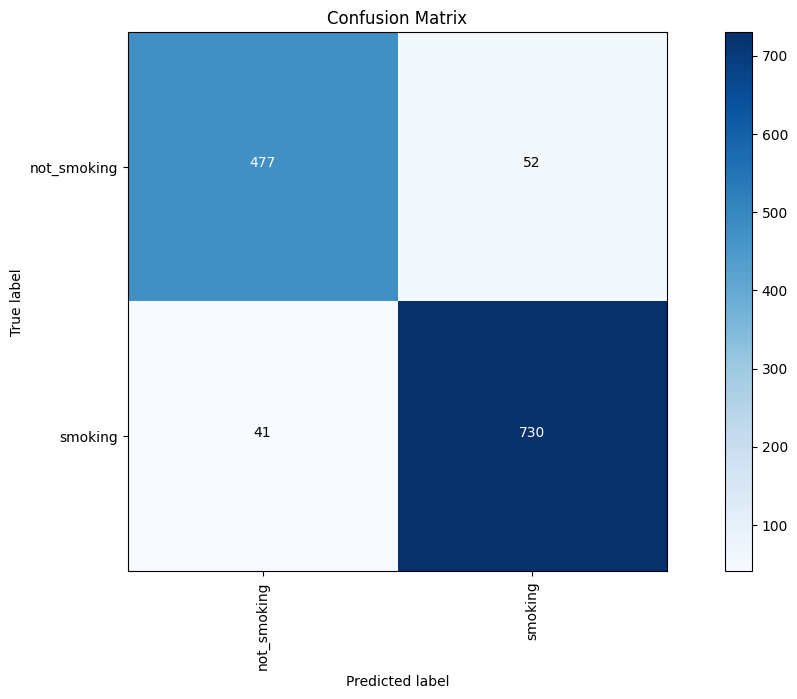

In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels."""
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    n_classes = cm.shape[0]

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=labels,
           yticklabels=labels)

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)

    if savefig:
        fig.savefig("confusion_matrix.png")

make_confusion_matrix(y_test, pred, list(labels.values()))
